
# Preprocessing 
### This Notebook takes an image and the output is the binarized Image with horizontal staff lines
### It takes care of the enhancement of the image and choosing apropriate threshold


In [7]:
from commonfunctions import *


%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
def match_clif(image_path,clif_path):    
    
    img1 = cv2.imread(symbolPath,0)     # queryImage
    img2 = cv2.imread(p2,0) # trainImage

    # Initiate SIFT detector
    sift = cv2.xfeatures2d.SIFT_create()

    # find the keypoints and descriptors with SIFT
    imgL = img2[:,0:img2.shape[1]//2]
    imgR = img2[:,img2.shape[1]//2:img2.shape[1]]
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(imgL,None)
    kp3, des3 = sift.detectAndCompute(imgR,None)

    # FLANN parameters
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)   # or pass empty dictionary

    flann = cv2.FlannBasedMatcher(index_params,search_params)

    matchesL = flann.knnMatch(des1,des2,k=1)
    matchesR = flann.knnMatch(des1,des3,k=1)

    sumL = 0
    for match in matchesL:
        sumL += match[0].distance
    # print(sumL)
    sumR = 0
    for match in matchesR:
        sumR += match[0].distance
    # print(sumR)
    # print(len(matchesL),len(matchesR))
    
    # # Need to draw only good matches, so create a mask
    # img3 = cv2.drawMatchesKnn(img1,kp1,imgL,kp2,matchesL,img2,flags = 2)
    # # img4 = cv2.drawMatchesKnn(img1,kp1,imgR,kp2,matchesR,img2,flags = 2)
    return sumL < sumR
    # plt.imshow(img3,),plt.show()
    # plt.imshow(img4,),plt.show()


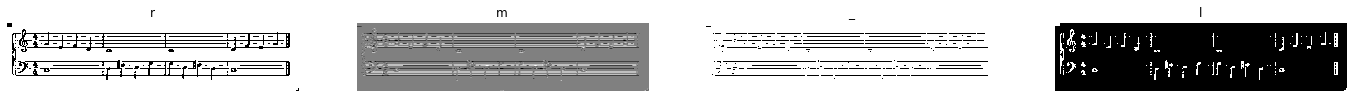

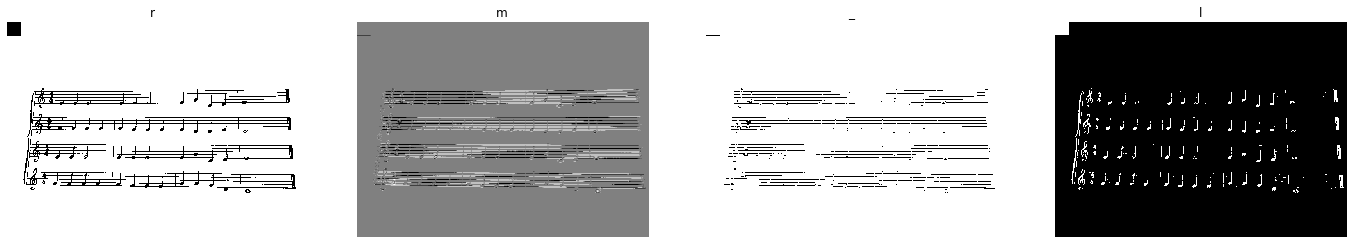

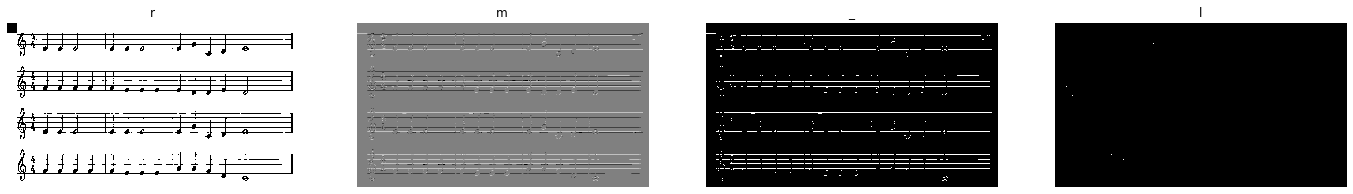

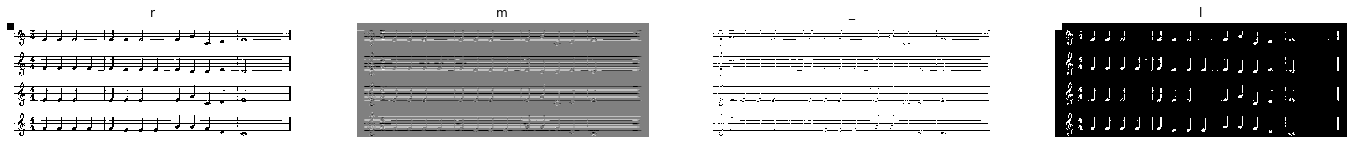

In [24]:
def rotate_img(image):
    new = np.array(np.where(image>0,0,1))
    tested_angles = np.linspace(-np.pi/2, np.pi/2, 360)
    origin = np.array((0,new.shape[1]))
    h, theta, d = hough_line(new, theta=tested_angles)
    th  = 0
#     ig, axes = plt.subplots(1, 3, figsize=(15, 6))
#     ax = axes.ravel()
#     ax[0].imshow(new, cmap=cm.gray)
    peaks = list(zip(*hough_line_peaks(h, theta, d)))
    _, angle, dist = np.median(peaks,axis = 0)
    y0,y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
    th = math.atan((y1 - y0 )/(origin[1]))
#         ax[0].plot(origin, (y0,y1), '-r')
    if math.degrees(th) > 5 or math.degrees(th)< -5: 
        return np.where(binarize(rotate(new,math.degrees(th),preserve_range= True))>0,0,1)
    return np.where(new>0,0,1)
   

h_m =  [[-1,-1,-1],[2,2,2],[-1,-1,-1]]
def binarize(img):
    thr = threshold_otsu(img)
    return np.where(img > thr,1,0)

paths = [ '../../bex2.png', '../../bex3.png', '../../bex4.png', '../../bex5.png']
#paths = [ '../../bex4.png']
k = 1
for p in paths:
    img = io.imread(p)
    gray = rgb2gray(img)
    gray = (gray*255).astype('uint8')
    org = binraization(gray)
    # org = rotate_img(org)
    new = convolve(org, h_m, mode='constant', cval=0.0)
    binary = binarize(new)
    done = binary * np.where(org>0,0,1)
    show_images([org,new,binary,done],'rm_lines')

In [10]:
from scipy.signal import find_peaks
def getStuffLines(bin_img):
    hist = np.zeros(bin_img.shape[0])
    for i in range(bin_img.shape[0]):
        hist[i] = np.sum(np.where(bin_img[i,:]>0,0,1))
    # plt.figure()
    # plt.plot(np.arange(0,bin_img.shape[0],1),hist,label = 'hist')
    peaks, _ = find_peaks(hist, height = bin_img.shape[0]//2,distance=7)
    np.diff(peaks)
    # plt.plot(peaks, hist[peaks], "x")
    # plt.show()
    return peaks
def get_obj_properties(obj_y,img):
    stuff_lines_pos = getStuffLines(img)
    print(stuff_lines_pos)
    # get differece between object and lines
    diff = stuff_lines_pos - obj_y
    # get min difference disregarding the sign
    min_pos = np.where(np.absolute(diff) == np.min(np.absolute(diff)))
    #git closes line position
    closest_line_pos= stuff_lines_pos[min_pos]
    #get line above if negative and below if positive 
    sign = diff[min_pos]# distance between top of obejct and nearest line
    closest_line_num = np.where(stuff_lines_pos == closest_line_pos)[0]+1
    closest_line_num = closest_line_num[0]
    return closest_line_num, closest_line_pos, sign

img = io.imread('../../bex2.png')
gray = rgb2gray(img)
gray = (gray*255).astype('uint8')
org = binraization(gray)
obj_min_y = 22  # min y in contour 
obj_max_y = 40  # max y in contour
obj_type = 'reverse first type'

closest_line_num_top, closest_line_pos_top, sign_top= get_obj_properties(obj_min_y,org)
closest_line_num_d, closest_line_pos_d, sign_d= get_obj_properties(obj_max_y,org)

# print(closest_line_num_top)
# print(closest_line_pos_top) 
# print(sign_top) 

# print(closest_line_num_d)
# print(closest_line_pos_d) 
# print(sign_d)  

def get_org_txt(obj_type, closest_line_num_d, closest_line_pos_d, sign_d):
    if obj_type == 'first type':
        if sign_top  > 0 and sign_d == 0 and closest_line_num_top % 1 == 0 and closest_line_num_d % 4 == 0:#if obj top above line and object bottom on line 
            return 'a'
        elif sign_top  > 0 and sign_d < 0 and closest_line_num_top % 1 == 0 and closest_line_num_d % 4 == 0: #if obj top above line and object bottom below line 
            return 'g'
        elif sign_top  == 0 and sign_d == 0 and closest_line_num_top % 1 == 0 and closest_line_num_d % 5 == 0: #if obj top on line and object bottom on line 
            return 'f'
        elif sign_top  > 0 and sign_d < 0 and closest_line_num_top % 2 == 0 and closest_line_num_d % 5 == 0: #if obj top above line and object bottom below line 
            return 'e'   
        elif sign_top  == 0 and sign_d < 0 and closest_line_num_top % 2 == 0 and closest_line_num_d % 5 == 0: #if obj top on line and object bottom below line 
            return 'd' 
        elif sign_top  > 0 and sign_d < 0 and closest_line_num_top % 3 == 0 and closest_line_num_d % 5 == 0: #if obj top above line and object bottom below line 
            return 'c' 
    elif obj_type == 'reverse first type':
        if sign_top  > 0 and sign_d == 0 and closest_line_num_top % 1 == 0 and closest_line_num_d % 3 == 0:#if obj top above line and object bottom on line 
            return 'b2  '
        elif sign_top  > 0 and sign_d < 0 and closest_line_num_top % 1 == 0 and closest_line_num_d % 3 == 0:#if obj top above line and object bottom on line 
            return 'a2  '
        elif sign_top  > 0 and sign_d == 0 and closest_line_num_top % 1 == 0 and closest_line_num_d % 4 == 0:#if obj top above line and object bottom on line 
            return 'g2'
        elif sign_top  > 0 and sign_d < 0 and closest_line_num_top % 1 == 0 and closest_line_num_d % 4 == 0: #if obj top above line and object bottom below line 
            return 'f2'
        elif sign_top  == 0 and sign_d == 0 and closest_line_num_top % 1 == 0 and closest_line_num_d % 5 == 0: #if obj top on line and object bottom on line 
            return 'e2'
        elif sign_top  > 0 and sign_d < 0 and closest_line_num_top % 2 == 0 and closest_line_num_d % 5 == 0: #if obj top above line and object bottom below line 
            return 'd2'   
        elif sign_top  == 0 and sign_d < 0 and closest_line_num_top % 2 == 0 and closest_line_num_d % 5 == 0: #if obj top on line and object bottom below line 
            return 'c2' 
        elif sign_top  > 0 and sign_d < 0 and closest_line_num_top % 3 == 0 and closest_line_num_d % 5 == 0: #if obj top above line and object bottom below line 
            return 'b' 
    
org_txt = get_org_txt(obj_type,closest_line_num_d, closest_line_pos_d, sign_d)
print(org_txt)









FileNotFoundError: No such file: 'C:\Users\eslam\Desktop\IP project\bex2.png'

In [279]:
def deleteLines(binary,w):
    theta = np.arange(-math.pi,math.pi,0.01)
    max_R = math.sqrt(binary.shape[0]**2 +  binary.shape[1]**2)
    vote_mat = np.zeros((int(theta.size),int(round(max_R))))
    for row in range(binary.shape[0]):
        for col in range(binary.shape[1]):
             if binary[row,col]==1:
                for i in range(theta.size):
                    R = math.cos(theta[i]) * col + math.sin(theta[i]) * row
                    if  R < int(round(max_R)) and R >= 0:
                        vote_mat[i,int(R)]+=1
    for j in range(vote_mat.shape[0]):
        for k in range(vote_mat.shape[1]):
            if vote_mat[j,k] > 100:
                thval = theta[j]
                rval = k
                for i in range(binary.shape[1]):
                    x1 = i
                    y1 = int(round((rval - math.cos(thval)*x1)/ math.sin(thval)))
                    if not binary[y1-w:y1,x1].all() and not binary[y1:y1+w,x1].all():
                        binary[y1,x1] = 0
    show_images([binary],['line removed'])
    return binary

In [54]:
paths = ['../../ex1.png', '../../ex2.png', '../../ex3.png', '../../ex4.png', '../../ex5.png']
for i in paths:
# i = '../../ex4.png'
    img = sk.img_as_ubyte(rgb2gray(io.imread(i)))
    imgb = binraization(img)
    img = getStaffLines(imgb)
    show_images([img])

#     thr = fr.threshold_otsu(img)
#     binary = np.where(img>thr, 1, 0)
#     lines_rv = deleteLines(binary,3)
#     staffHeight, spaceHeight = getRefLengths(binary)


NameError: name 'getRefLengths' is not defined

time: 0.08877754211425781 seconds


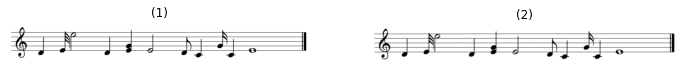

---------------------------------------------------------
time: 0.20245814323425293 seconds


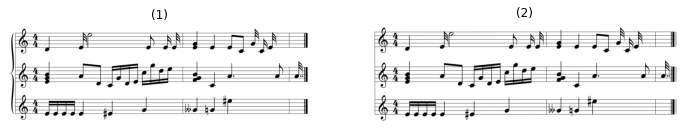

---------------------------------------------------------
time: 0.08577132225036621 seconds


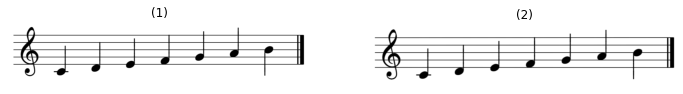

---------------------------------------------------------
time: 0.0828104019165039 seconds


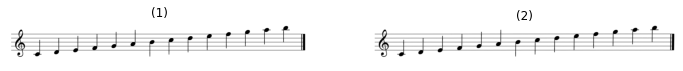

---------------------------------------------------------
time: 0.07878947257995605 seconds


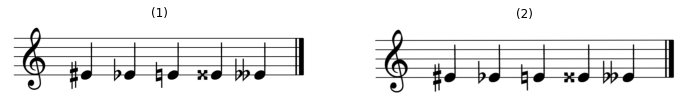

---------------------------------------------------------
time: 0.07483172416687012 seconds


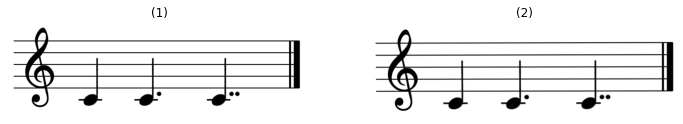

---------------------------------------------------------
time: 0.07184076309204102 seconds


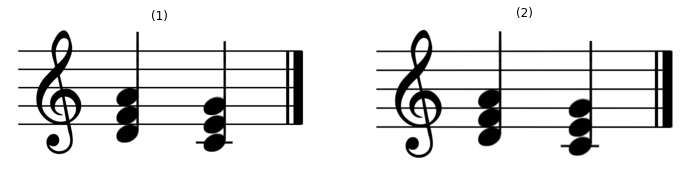

---------------------------------------------------------
time: 0.0747992992401123 seconds


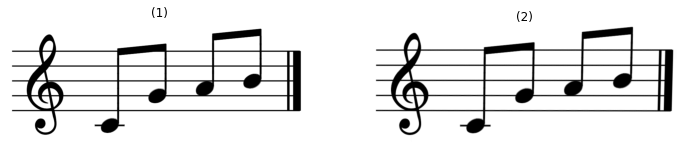

---------------------------------------------------------
time: 0.08879446983337402 seconds


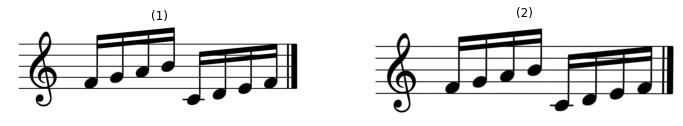

---------------------------------------------------------
time: 0.06382942199707031 seconds


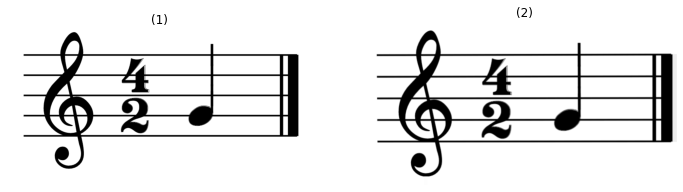

---------------------------------------------------------
time: 0.7629950046539307 seconds


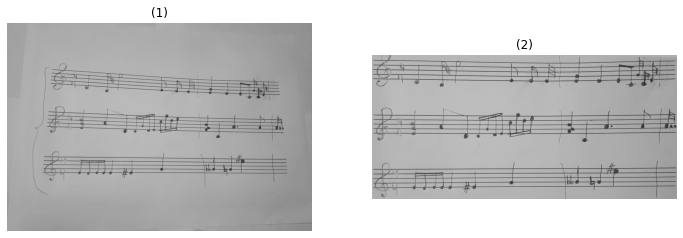

---------------------------------------------------------
time: 0.8477668762207031 seconds


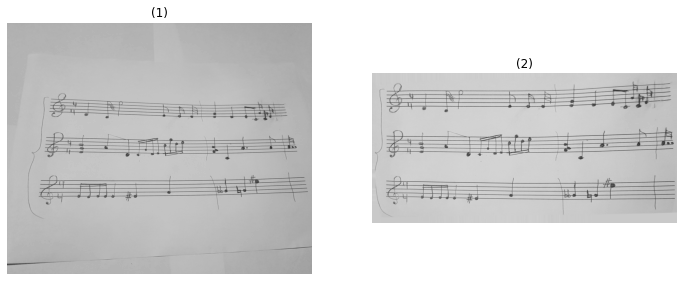

---------------------------------------------------------
time: 0.9045798778533936 seconds


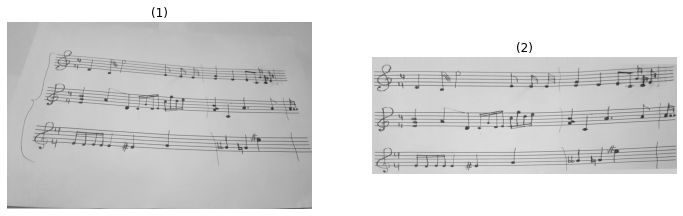

---------------------------------------------------------
time: 0.9464600086212158 seconds


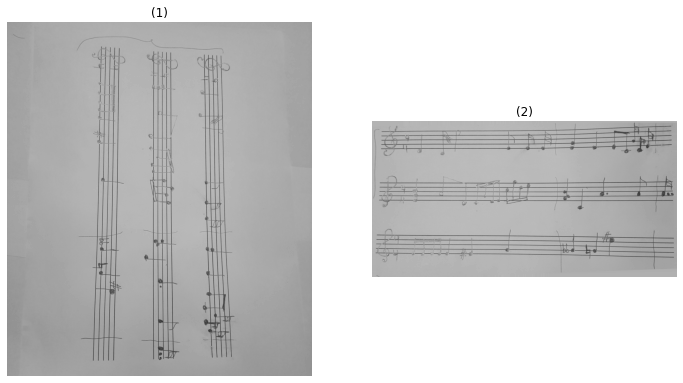

---------------------------------------------------------
time: 0.9185745716094971 seconds


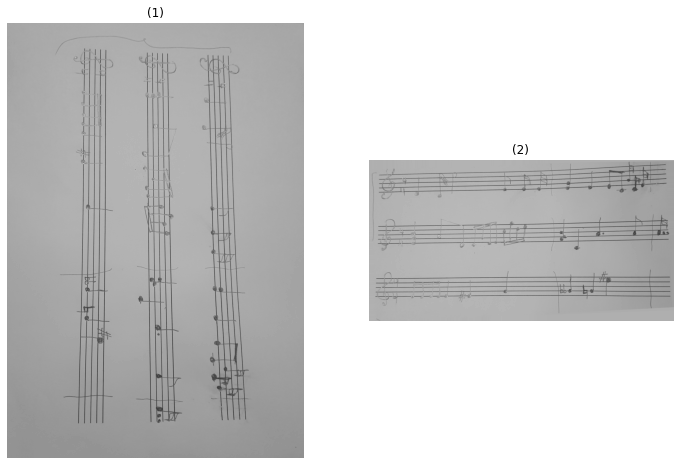

---------------------------------------------------------
time: 0.7379953861236572 seconds


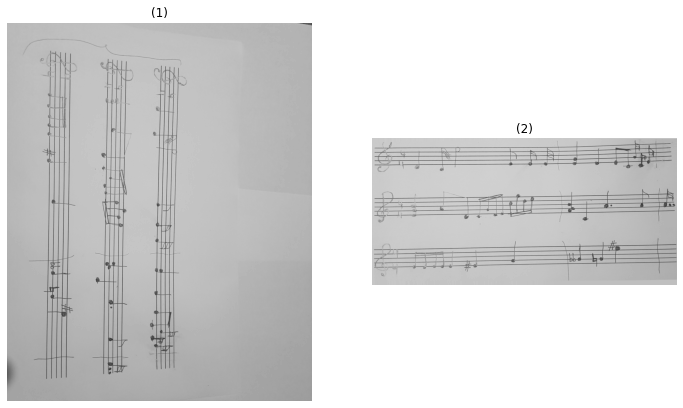

---------------------------------------------------------
time: 0.860731840133667 seconds


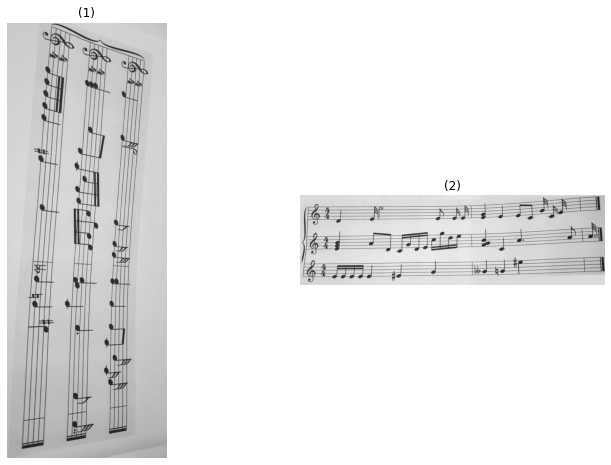

---------------------------------------------------------
time: 1.1259658336639404 seconds


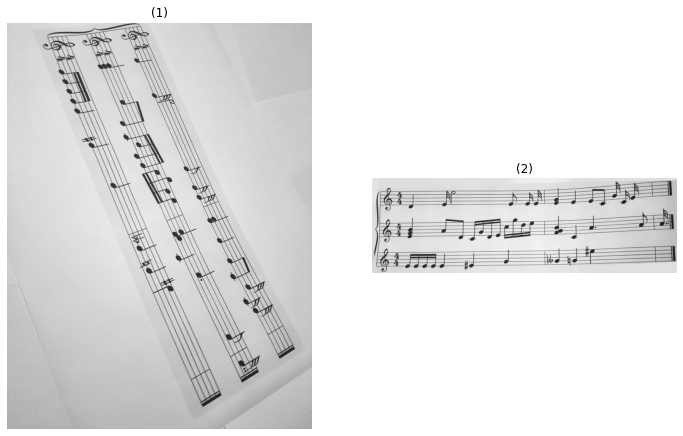

---------------------------------------------------------
time: 0.8457374572753906 seconds


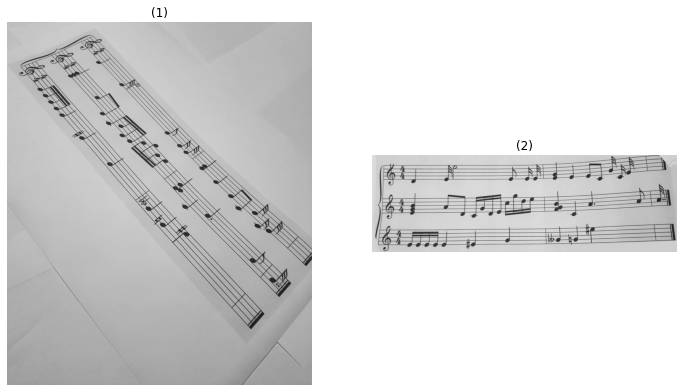

---------------------------------------------------------
time: 0.6991314888000488 seconds


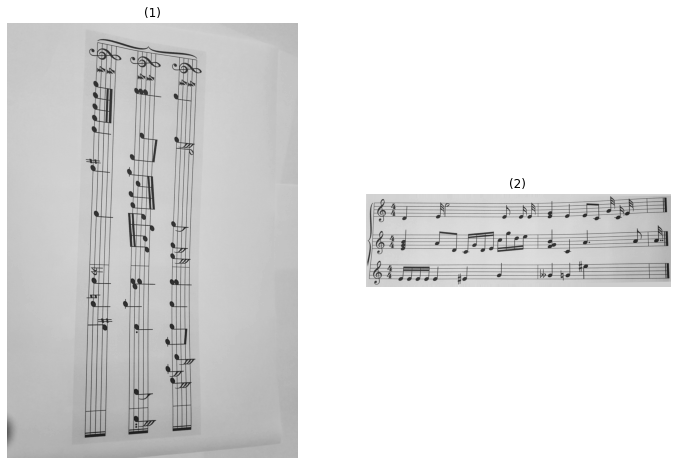

---------------------------------------------------------
time: 0.7689430713653564 seconds


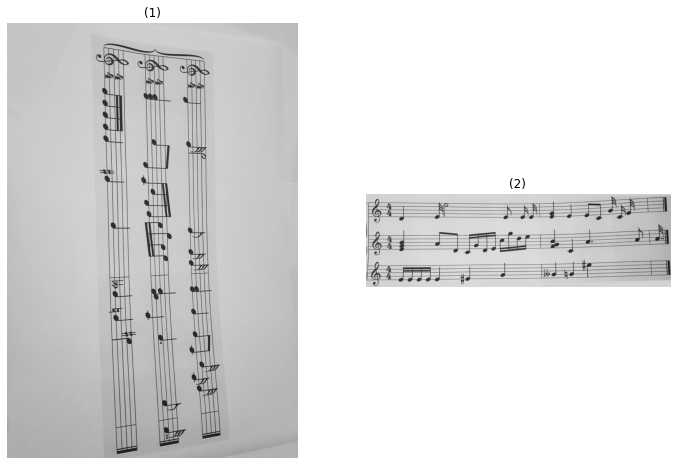

---------------------------------------------------------
time: 0.8188095092773438 seconds


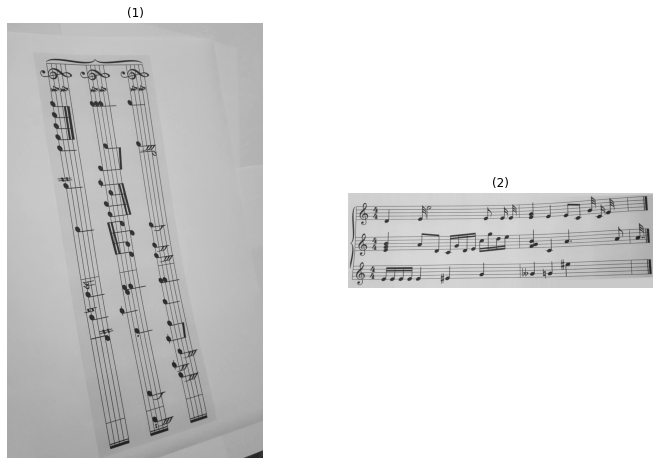

---------------------------------------------------------
time: 0.7519886493682861 seconds


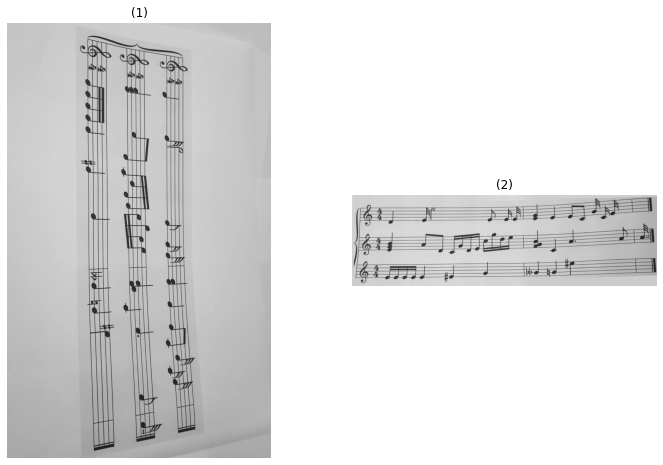

---------------------------------------------------------
time: 0.725060224533081 seconds


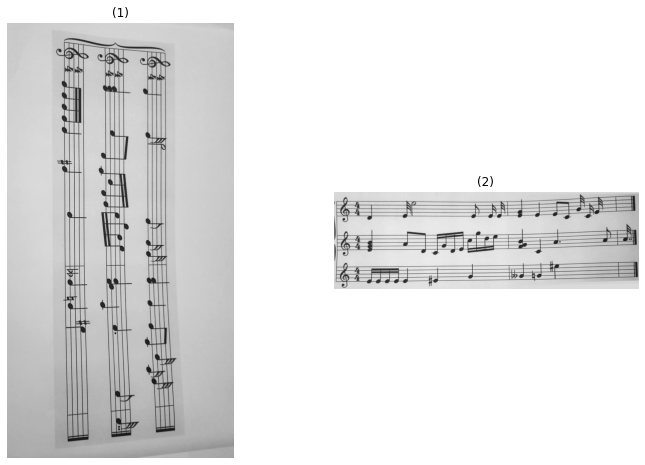

---------------------------------------------------------
time: 0.18151402473449707 seconds


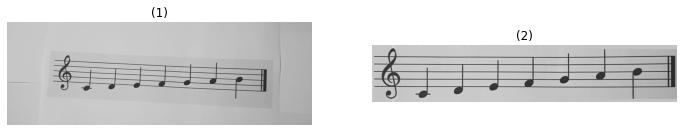

---------------------------------------------------------
time: 0.1934819221496582 seconds


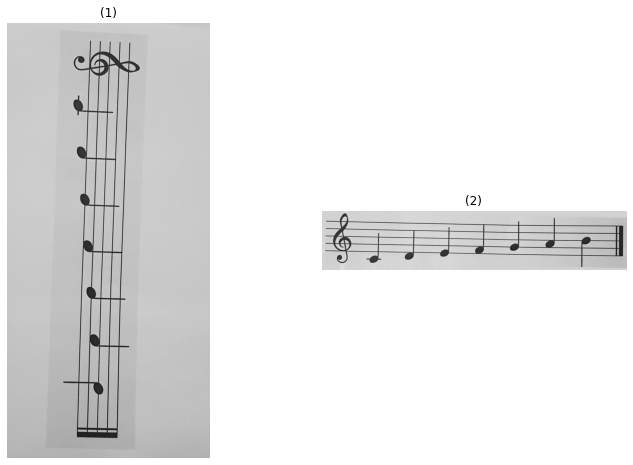

---------------------------------------------------------
time: 0.27127981185913086 seconds


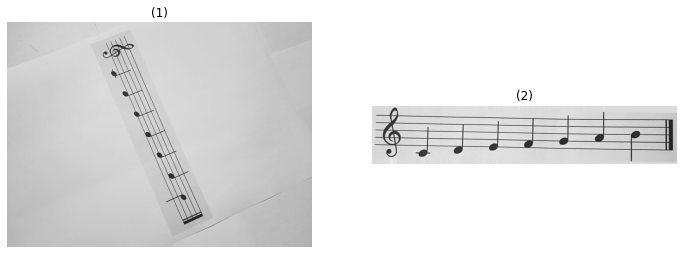

---------------------------------------------------------
time: 0.30019640922546387 seconds


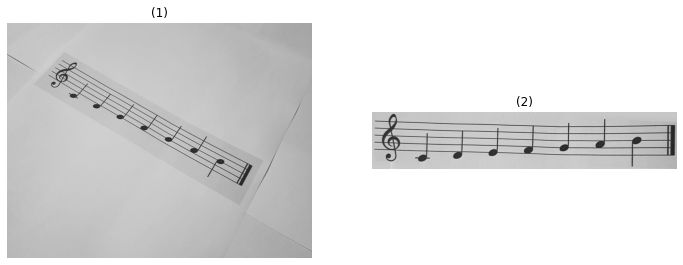

---------------------------------------------------------
time: 0.33610057830810547 seconds


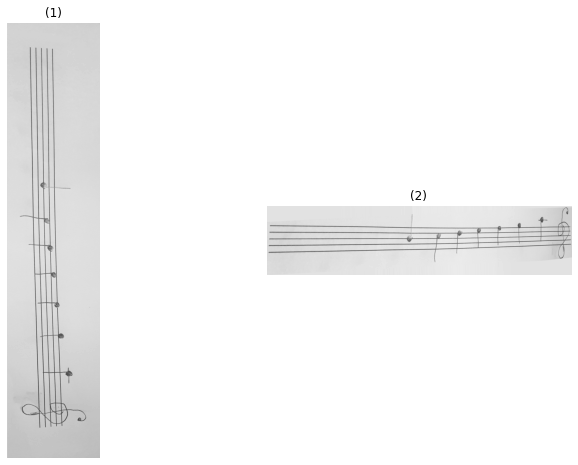

---------------------------------------------------------
time: 0.34707164764404297 seconds


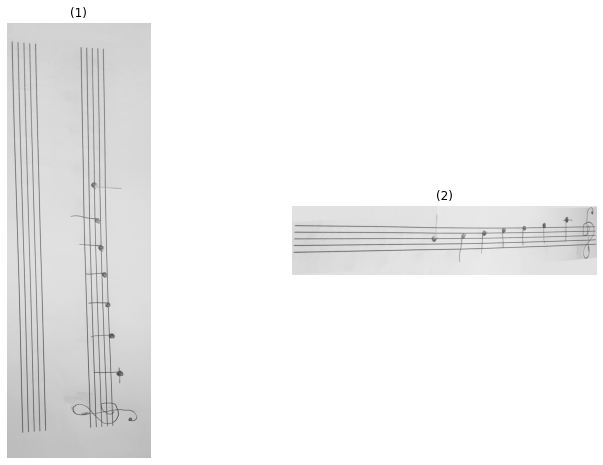

---------------------------------------------------------
time: 0.5275881290435791 seconds


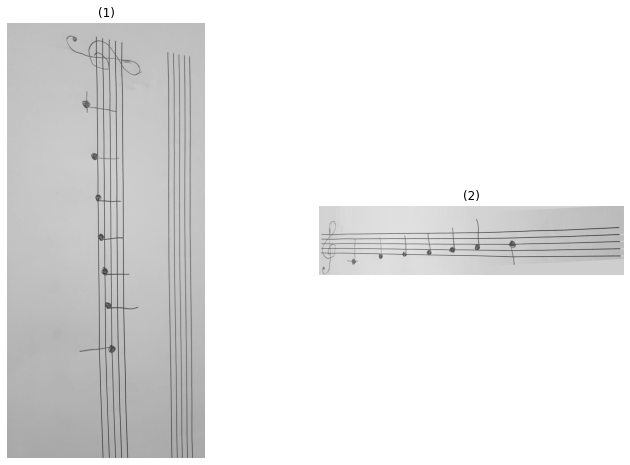

---------------------------------------------------------
time: 0.31016993522644043 seconds


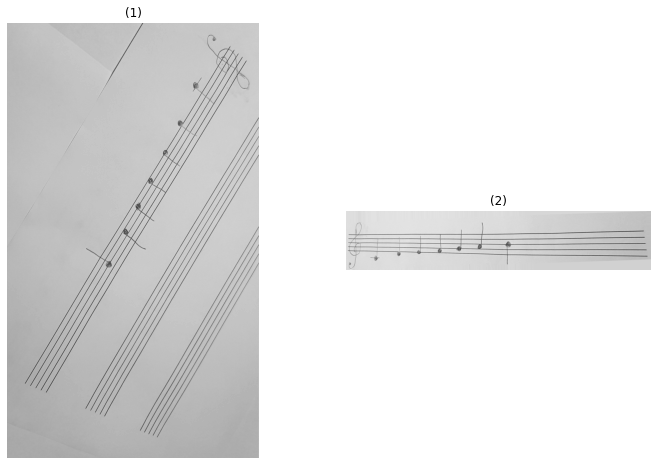

---------------------------------------------------------
time: 0.1406240463256836 seconds


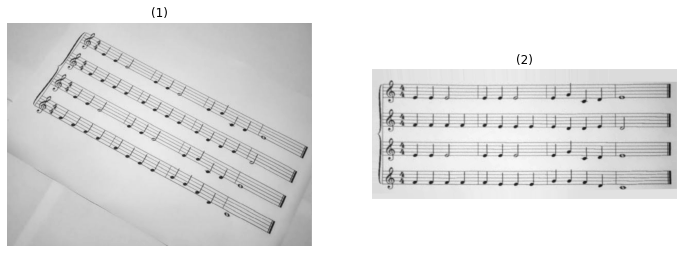

---------------------------------------------------------
time: 0.027957677841186523 seconds


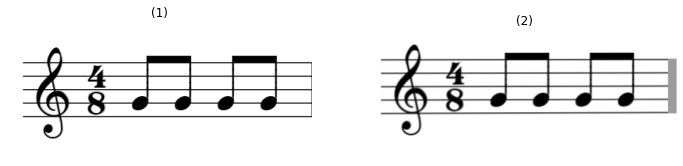

---------------------------------------------------------
time: 0.22739124298095703 seconds


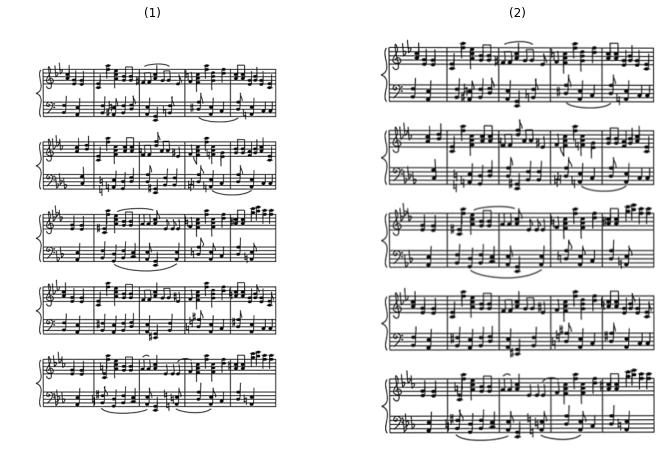

---------------------------------------------------------
time: 0.13164949417114258 seconds


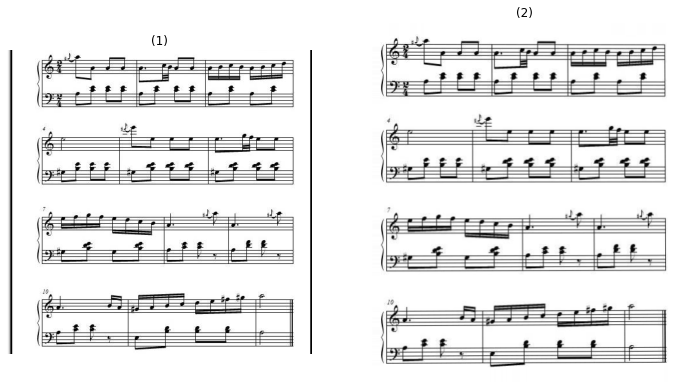

---------------------------------------------------------
time: 0.04590320587158203 seconds


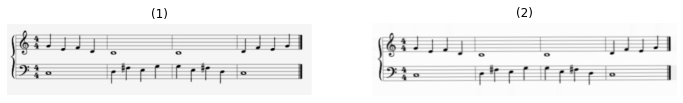

---------------------------------------------------------
time: 0.11472630500793457 seconds


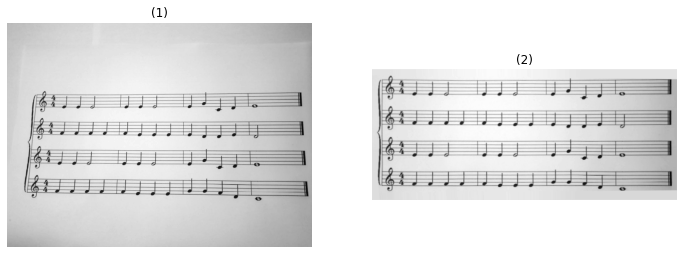

---------------------------------------------------------
time: 0.20545005798339844 seconds


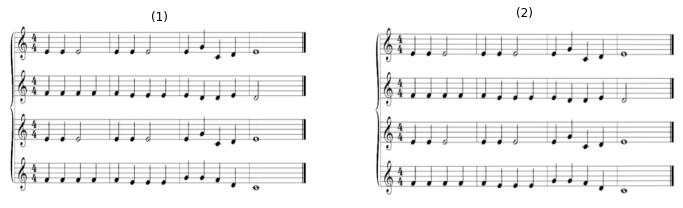

---------------------------------------------------------
time: 0.10375452041625977 seconds


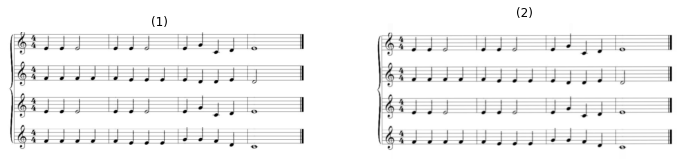

---------------------------------------------------------
time: 0.08679437637329102 seconds


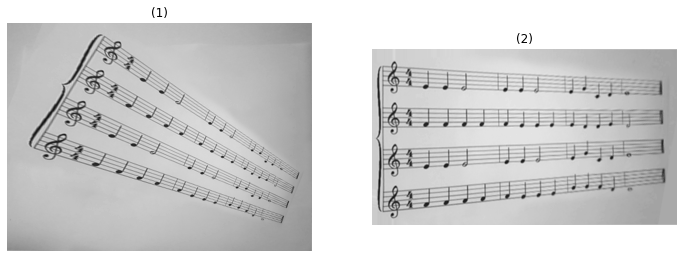

---------------------------------------------------------
time: 0.07377433776855469 seconds


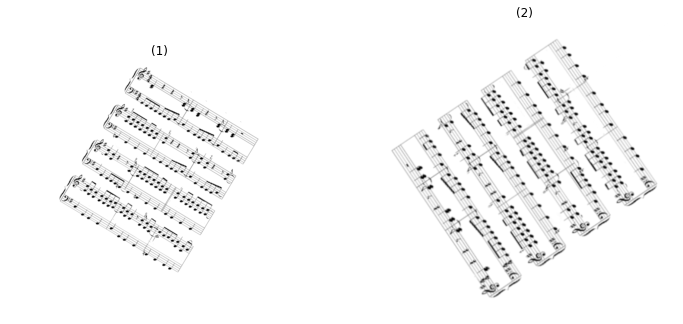

---------------------------------------------------------
time: 0.06585693359375 seconds


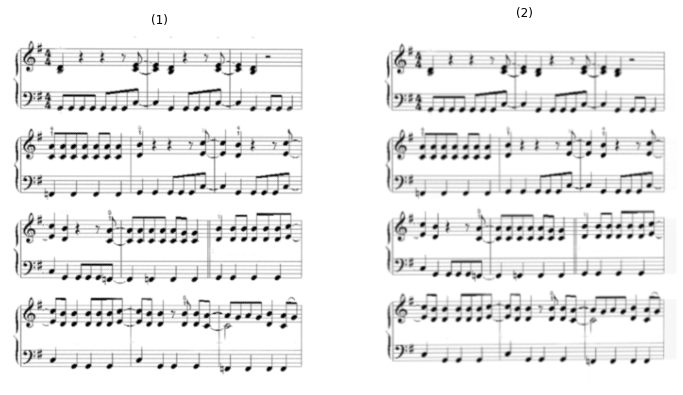

---------------------------------------------------------
time: 0.121673583984375 seconds


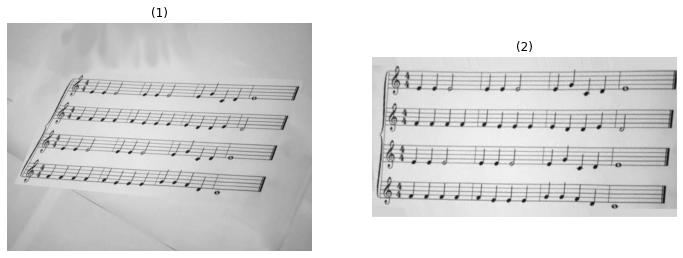

---------------------------------------------------------


In [26]:
images = load_images_from_folder("../test_cases/")
# images = [cv2.imread('../test_cases/04.PNG',0)]
# show_images([rotateImage(images[0])])

for img in images:
    start_time = time.time()
    area = rotateImage(img)
    print("time: %s seconds" % (time.time() - start_time))
    show_images([img, area])
    print("---------------------------------------------------------")
    

In [95]:
# img = cv2.imread('../test_cases/02.PNG', 0)
# # show_images([img])
# # binary = binraization(img)/255
# # show_images([binary])
# img = rotateImage(img)
# # show_images([img])
# binary = binraization(img)/255
# # show_images([binary])

# staffHeight, spaceHeight = getRefLengths(binary)
# filteredImg, candidates = getCandidateStaffs(binary, staffHeight)
# filteredImg1, candidates, eliminated = RemoveThinStaffs(candidates, filteredImg, staffHeight)
# filteredImg2, candidates, eliminated = removeLonelyStaffs(candidates, binary, staffHeight, spaceHeight, eliminated)
# filteredImg3, candidates = addFalseNegatives(candidates, filteredImg2, staffHeight, staffHeight, eliminated)
# print(filteredImg3)
staffLess = (binary-filteredImg3).astype(np.uint8)

show_images([staffLess])

lines = getLines(1-filteredImg3,staffHeight, spaceHeight)
# print(peaks)
# normalized_sum = rows_sum/filteredImg3.shape[1]
# t = 0.5
detected_lines = np.zeros(rows_sum.shape)
detected_lines[lines] = 1

show_images([binary])

starts = np.array((detected_lines[:-1] == 1) & (detected_lines[1:] == 0))
starts_ix = np.where(starts)[0] + 1
ends = np.array((detected_lines[:-1] == 0) & (detected_lines[1:] == 1))
ends_ix = np.where(ends)[0]

starts_ix = starts_ix[:-1]
ends_ix = ends_ix[1:]

halfs = [0]

for i in range(len(starts_ix)):
    diff = ends_ix[i] - starts_ix[i]
    if diff > 2 * spaceHeight:
        halfs.append((ends_ix[i] + starts_ix[i])//2)

halfs.append(filteredImg3.shape[0]-1)

# closing = cv2.morphologyEx(staffLess, cv2.MORPH_CLOSE, kernel)

# show_images([closing])
# print(halfs)
staffLessWithLines = cv2.cvtColor(staffLess, cv2.COLOR_GRAY2BGR)

staffLessWithLines[lines] = [255,0,0]
# staffLessWithLines[lines-1] = [255,0,0]
# staffLessWithLines[lines+1] = [255,0,0]

show_images([staffLessWithLines])
for i in range(len(halfs) - 1):
    segment = staffLess[halfs[i]:halfs[i+1] + 1]
    segmentWithLines = staffLessWithLines[halfs[i]:halfs[i+1] + 1]

#     show_images([segment])
    contours, hierarchy = cv2.findContours(segment, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

#     cp = cv2.cvtColor(segment, cv2.COLOR_GRAY2BGR)

#     for c in contours:
#         (x,y,w,h) = cv2.boundingRect(c)
#         min_x, max_x = x, x+w
#         min_y, max_y = y, y+h
#         cv2.rectangle(cp, (min_x,min_y), (max_x,max_y), (0, 255, 0), 3)
    
#     show_images([cp])
    boundingBoxes = [cv2.boundingRect(c) for c in contours]
    boundingBoxes = sorted(boundingBoxes, key=lambda b: b[0])
    
    
    (x,y,w,h) = boundingBoxes[0]
    mergedBoxes = [(x,y,x+w,y+h)]
    j = 0
    for i in range(1, len(boundingBoxes)):
        (x,y,w,h) = boundingBoxes[i]
        old_x,old_y,old_x2,old_y2 = mergedBoxes[j]
        
        if x < old_x2 or h < spaceHeight:
            mergedBoxes[j] = (min(old_x,x), min(old_y,y), max(old_x2,x+w), max(old_y2,y+h))
        else:
            mergedBoxes.append((x,y,x+w,y+h))
            j += 1
    
    cp = cv2.cvtColor(segment, cv2.COLOR_GRAY2BGR)
#     print(spaceHeight)
    show_images([segment])
    for b in mergedBoxes:
        if (b[2] - b[0]) > 3 * spaceHeight:
            cv2.rectangle(cp, (b[0],b[1]), (b[2],b[3]), (0, 255, 0), 1)
    
            hists, numberOfBeams = getNoteHeads(segment, (b[0],b[1],b[2]-b[0],b[3]-b[1]), staffHeight, spaceHeight)
#             print(numberOfBeams)
            show_images([segmentWithLines[b[1]:b[3], b[0]:b[2]]])
            for h in hists:
                _, top, distanceTop = getNearestLine(h[2],lines)
                _, bottom, distanceBottom = getNearestLine(h[3],lines)
                print(top, distanceTop, bottom, distanceBottom)
                character = getHeadCharacter(top, distanceTop, bottom, distanceBottom, spaceHeight)
                division = int(8*numberOfBeams)
#                 print(character, division)
                print(character + '/' + str(division))
#                 cv2.circle(cp, (h[1], h[2]), 2, (0, 255, 0), -1)
#                 cv2.circle(cp, (h[1], h[3]), 2, (0, 0, 255), -1)
    
#     print(1)
#     show_images([cp])
    
#     show_images([cp])
    io.imsave('contours' + str(i) + '.png',cp)
    
#     print(boundingBoxes)
#     (contours, boundingBoxes) = zip(*sorted(zip(contours, boundingBoxes),key=lambda b:b[1][i]))


# cp = cv2.cvtColor(staffLess, cv2.COLOR_GRAY2BGR)


# for c in contours:
#     (x,y,w,h) = cv2.boundingRect(c)
#     min_x, max_x = x, x+w
#     min_y, max_y = y, y+h
#     cv2.rectangle(cp, (min_x,min_y), (max_x,max_y), (255, 0, 0), 1)

# cp[halfs] = [0,0,255]
# # io.imsave('contours.png',cp)
# show_images([cp])
# io.imsave('removed.png',binary)

ValueError: operands could not be broadcast together with shapes (692,923) (574,1559) 

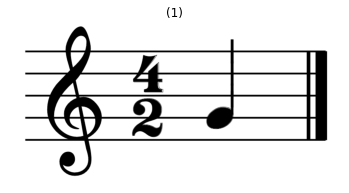

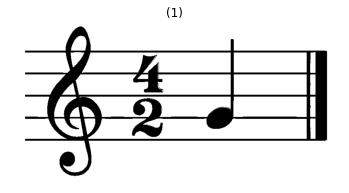

5 52
1
105 9 247 399
142 390
329 83 388 155
59 72

2
329 83 388 155
59 72
326 196 405 297
79 101

3
326 196 405 297
79 101
351 198 352 206
1 8

4
351 198 352 206
1 8
359 102 407 181
48 79

5
351 102 407 206
56 104
356 197 359 205
3 8

6
356 197 359 205
3 8
329 199 359 241
30 42

7
329 197 359 241
30 44
387 84 388 86
1 2

8
329 84 388 241
59 157
390 83 391 85
1 2

9
329 83 391 241
62 158
520 42 591 276
71 234

10
520 42 591 276
71 234
562 218 564 219
2 1

11
562 218 564 219
2 1
781 72 791 307
10 235

12
781 72 791 307
10 235
804 72 834 307
30 235



In [8]:
img = cv2.imread('../test_cases/10.PNG', 0)
show_images([img])
# plt.imsave('img1.png', img)
# binary = binraization(img)//255
# show_images([binary])
# img = rotateImage(img)
# show_images([img], ["rotated"])
# plt.imsave('img2.png', img)

binary = binraization(img)//255
show_images([binary])

staffHeight, spaceHeight = getRefLengths(binary)
filteredImg, candidates = getCandidateStaffs(binary, staffHeight)
filteredImg1, candidates, eliminated = RemoveThinStaffs(candidates, filteredImg, staffHeight)
filteredImg2, candidates, eliminated = removeLonelyStaffs(candidates, binary, staffHeight, spaceHeight, eliminated)
filteredImg3, candidates = addFalseNegatives(candidates, filteredImg2, staffHeight, staffHeight, eliminated)
# print(filteredImg3)
staffLess = (binary-filteredImg3).astype(np.uint8)

plt.imsave('binary.png', binary)
plt.imsave('staffless.png', staffLess)

# start = time.time()
lines = getLines(1-filteredImg3, staffHeight, spaceHeight)
# print(time.time()-start)

cp = cv2.cvtColor(staffLess, cv2.COLOR_GRAY2BGR)
cp[lines] = [0,0,255]
plt.imsave('detectedLines.png', cp)


# start = time.time()
halfs = segmentImage(lines, spaceHeight, staffLess.shape[0])
# print(time.time()-start)

# total = time.time()
print(staffHeight, spaceHeight)

for i in range(len(halfs) - 1):
#     print(staffHeight, spaceHeight)
    segment = staffLess[halfs[i]:halfs[i+1] + 1]
#     show_images([segment])
#     start = time.time()
    getObjects(segment, lines, halfs[i], staffHeight, spaceHeight, i)
#     break
#     print(time.time()-start)
# print(time.time()-total)    

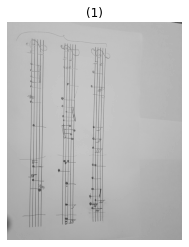

(3239, 2606)
156.0 1546.0 239.0 3083.0


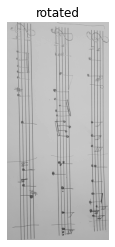

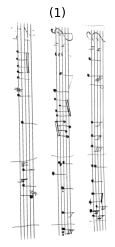

In [28]:
img = cv2.imread('../test_cases/16.jpg', 0)
show_images([img])
# plt.imsave('img1.png', img)
# binary = binraization(img)//255
# show_images([binary])
img = rotateImage(img)
show_images([img], ["rotated"])
# plt.imsave('img2.png', img)

binary = binraization(img)//255
show_images([binary])

staffHeight, spaceHeight = getRefLengths(binary)

In [ ]:
paths = ['../ex1.png', '../ex2.png', '../ex3.png', '../ex4.png', '../ex5.png', '../ex7.png', '../ex8.png']
scanned = ['01.PNG', '02.PNG', '03.PNG', '04.PNG', '05.PNG', '06.PNG', '07.PNG', '08.PNG', '09.PNG', '10.PNG']
for i in scanned:
# i = '../ex1.png'
    img = (cv2.imread('../databases/PublicTestCases/test-set-scanned/test-cases/'+i))
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    se = np.ones((1, 9))
    binary = binraization(gray)
    
    staffHeight, spaceHeight = getRefLengths(binary)
    filteredImg, candidates = getCandidateStaffs(binary, staffHeight)
#     filteredImg = binary_opening(filteredImg, se)
    filteredImg1, candidates, eliminated = RemoveThinStaffs(candidates, filteredImg, staffHeight)
    filteredImg2, candidates, eliminated = removeLonelyStaffs(candidates, binary, staffHeight, spaceHeight, eliminated)
    filteredImg3, candidates = addFalseNegatives(candidates, filteredImg2, staffHeight, staffHeight, eliminated)
    staffless = (binary-filteredImg3).astype(np.uint8)
    
    
    image, contours, hierarchy = cv2.findContours(staffless*255, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) 
    original = img.copy()
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        if h > spaceHeight*2 and w >= spaceHeight/2 and w <= 2*spaceHeight:
            cv2.rectangle(original, (x,y), (x+w, y+h), (0,255,0), 3)
            cv2.rectangle(staffless, (x,y), (x+w, y+h), 255, 3)

    cv2.imwrite('notes'+i, original)


In [8]:
def fillBridges(binary,staffless,offset = 5):
    img1 = staffless.copy()
    binary = np.where(binary>0,0,1)
    for i in range(staffless.shape[0] - offset): 
        for j in range(staffless.shape[1]- offset):
            if staffless[i,j] == 1 and staffless[i,j+offset] == 1:
                img1[i,j:j+offset] = binary[i,j:j+offset]
            if staffless[i,j] == 1 and staffless[i+offset,j] == 1:
                img1[i:i+offset,j] = binary[i:i+offset,j]
    return img1

6 29


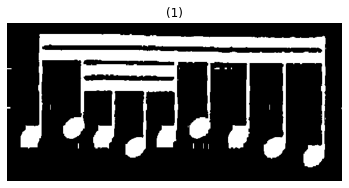

2
0.032910823822021484


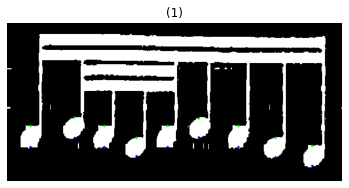

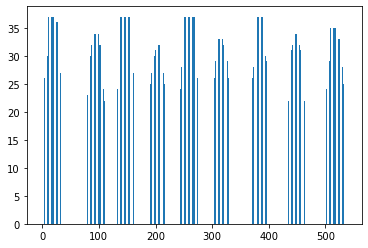

In [152]:
img = cv2.imread('../test_cases/beam.png', 0)
# show_images([img])
# binary = binraization(img)/255
# show_images([binary])
# img = rotateImage(img)
# show_images([img])
binary = binraization(img)/255
# show_images([binary])

staffHeight, spaceHeight = getRefLengths(binary)
print(staffHeight, spaceHeight)
filteredImg, candidates = getCandidateStaffs(binary, staffHeight)
filteredImg1, candidates, eliminated = RemoveThinStaffs(candidates, filteredImg, staffHeight)
filteredImg2, candidates, eliminated = removeLonelyStaffs(candidates, binary, staffHeight, spaceHeight, eliminated)
filteredImg3, candidates = addFalseNegatives(candidates, filteredImg2, staffHeight, staffHeight, eliminated)
# print(filteredImg3)
staffLess = (binary-filteredImg3).astype(np.uint8)//255

show_images([staffLess])


rows_sum = np.sum(1-filteredImg3, axis=1)

lines, _ = find_peaks(rows_sum, height = staffLess.shape[1]//2, distance=spaceHeight)
# print(peaks)
# normalized_sum = rows_sum/filteredImg3.shape[1]
# t = 0.5
detected_lines = np.zeros(rows_sum.shape)
detected_lines[lines] = 1

contours, hierarchy = cv2.findContours(staffLess, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key = cv2.contourArea, reverse = True)

largestContour = contours[0]
(x,y,w,h) = cv2.boundingRect(largestContour)
min_x, max_x = x, x+w
min_y, max_y = y, y+h

# cv2.rectangle(cp, (min_x,min_y), (max_x,max_y), (255, 0, 0), 1)
cp = cv2.cvtColor(staffLess*255, cv2.COLOR_GRAY2BGR)

start = time.time()

hists,beams = getNoteHeads(staffLess, (x,y,w,h), staffHeight, spaceHeight)

print(beams)

for h in hists:
    cv2.circle(cp, (h[1], h[2]), 2, (0, 255, 0), -1)
    cv2.circle(cp, (h[1], h[3]), 2, (0, 0, 255), -1)
    
    
# print(w)
# print(hist[hist[:,0] != 0])
print(time.time() - start)
# cp[peaks, :] = [255,255,255]
show_images([cp])
plt.imsave('test.png', cp)
# plt.plot(hist[:,0], range(w))
# plt.hist(hist[:,0], bins =w)
plt.bar(range(w), hist[:,0], width=0.5)
plt.show()



In [39]:
def lineseg_dists(p, a, b):
    """Cartesian distance from point to line segment

    Edited to support arguments as series, from:
    https://stackoverflow.com/a/54442561/11208892

    Args:
        - p: np.array of single point, shape (2,) or 2D array, shape (x, 2)
        - a: np.array of shape (x, 2)
        - b: np.array of shape (x, 2)
    """
    # normalized tangent vectors
    d_ba = b - a
    d = np.divide(d_ba, (np.hypot(d_ba[:, 0], d_ba[:, 1])
                           .reshape(-1, 1)))

    # signed parallel distance components
    # rowwise dot products of 2D vectors
    s = np.multiply(a - p, d).sum(axis=1)
    t = np.multiply(p - b, d).sum(axis=1)

    # clamped parallel distance
    h = np.maximum.reduce([s, t, np.zeros(len(s))])

    # perpendicular distance component
    # rowwise cross products of 2D vectors  
    d_pa = p - a
    c = d_pa[:, 0] * d[:, 1] - d_pa[:, 1] * d[:, 0]

    return np.hypot(h, c)

# p = np.array([5,2])
# a = np.array([[0,1]])
# b = np.array([[0,3]])

# print(lineseg_dists(p, a, b))


In [38]:
def getTheta(point1, point2):
    with np.errstate(divide='ignore'):
        m = (point2[0]-point1[0])/(point2[1]-point1[1])
    return math.atan(m)

In [40]:
def getPts(pts, shape):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype = "float32")
    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    theta1 = getTheta(rect[0], rect[1])
    theta2 = getTheta(rect[1], rect[2])
    theta3 = getTheta(rect[3], rect[2])
    theta4 = getTheta(rect[0], rect[3])
    
    print(math.degrees(theta1),math.degrees(theta2),math.degrees(theta3),math.degrees(theta4))
#     width = np.linalg.norm(rect[0]-rect[1])
#     height = np.linalg.norm(rect[1]-rect[2])
#     print(rect)
# #     print(shape)
#     const = min(shape[1],shape[0])/15
#     xConst = 0
#     yConst = 0
    
#     if shape[1] > 4000:
#         yConst = 250
#     elif shape[1] > 3500:
#         yConst = 250
#     elif shape[1] > 3000:
#         yConst = 200
#     elif shape[1] > 2500:
#         yConst = 100
#     elif shape[1] > 2000:
#         yConst = 70
#     elif shape[1] > 1500:
#         yConst = 50
#     elif shape[1] > 1000:
#         yConst = 30
#     elif shape[1] > 500:
#         yConst = 20
#     else:
#         yConst = 20
    
#     if shape[0] > 4000:
#         xConst = 250
#     elif shape[0] > 3500:
#         xConst = 250
#     elif shape[0] > 3000:
#         xConst = 200
#     elif shape[0] > 2500:
#         xConst = 100
#     elif shape[0] > 2000:
#         xConst = 70
#     elif shape[0] > 1500:
#         xConst = 50
#     elif shape[0] > 1000:
#         xConst = 30
#     elif shape[0] > 500:
#         xConst = 20
#     else:
#         xConst = 20
    

# #     print(xConst, yConst)
# #     print(shape)
    
# # # #     print(rect)
#     if rect[0,1] == rect[1,1]:
#         rect[0,0] -= xConst
#         rect[1,0] += xConst
#     else:
#         slope1 = (rect[1,1]-rect[0,1])/(rect[1,0]-rect[0,0])
#         y1 = rect[0,1]
#         x1 = rect[0,0]
#         rect[0,0] -= xConst
#         rect[1,0] += xConst
#         rect[0,1] = y1 + (rect[0,0] - x1) * slope1
#         rect[1,1] = y1 + (rect[1,0] - x1) * slope1
    
#     if rect[2,1] == rect[3,1]:
#         rect[2,0] += xConst
#         rect[3,0] -= xConst
#     else:
#         slope3 = (rect[3,1]-rect[2,1])/(rect[3,0]-rect[2,0])
#         y1 = rect[2,1]
#         x1 = rect[2,0]
#         rect[2,0] += xConst
#         rect[3,0] -= xConst
#         rect[2,1] = y1 + (rect[2,0] - x1) * slope3
#         rect[3,1] = y1 + (rect[3,0] - x1) * slope3
    
#     if rect[1,0] == rect[2,0]:
#         rect[1,1] -= yConst
#         rect[2,1] += yConst
#     else:
#         slope2 = (rect[2,1]-rect[1,1])/(rect[2,0]-rect[1,0])
#         y1 = rect[1,1]
#         x1 = rect[1,0]
#         rect[1,1] -= yConst
#         rect[2,1] += yConst
#         rect[1,0] = x1 + (rect[1,1] - y1) / slope2
#         rect[2,0] = x1 + (rect[2,1] - y1) / slope2
        
#     if rect[0,0] == rect[3,0]:
#         rect[0,1] -= yConst
#         rect[3,1] += yConst
#     else:
#         slope4 = (rect[3,1]-rect[0,1])/(rect[3,0]-rect[0,0])
#         y1 = rect[0,1]
#         x1 = rect[0,0]
#         rect[0,1] -= yConst
#         rect[3,1] += yConst
#         rect[0,0] = x1 + (rect[0,1] - y1) / slope4
#         rect[3,0] = x1 + (rect[3,1] - y1) / slope4
        
#     print('after')
#     print(shape)
#     print(rect)
        
    # return the ordered coordinates
    return rect

In [9]:
def downSize(image, width=1000):
    (h, w) = image.shape
    print(h, w)
    shrinkingRatio = width / float(w)
    dsize  = (width, int(h * shrinkingRatio))
    resized = cv2.resize(image, dsize , interpolation=cv2.INTER_AREA)
    return resized

img = cv2.imread('../test_cases/13.jpg', 0)
img1 = downSize(img)
print(img.shape)
print(img1.shape)

2358 3849
(2358, 3849)
(612, 1000)
